# Train from stratch

To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### News

**Read our [Gemma 3 blog](https://unsloth.ai/blog/gemma3) for what's new in Unsloth and our [Reasoning blog](https://unsloth.ai/blog/r1-reasoning) on how to train reasoning models.**

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


### Installation

In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

### Unsloth

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

<ipython-input-3-42e461b81fc5>:1: UserWarning: WARNING: Unsloth should be imported before transformers to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastVisionModel # FastLanguageModel for LLMs


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.19: Fast Mllama patching. Transformers: 4.51.1.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [ ]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.language_model` require gradients


<a name="Data"></a>
### Data Prep
We'll be using a sampled version of the ROCO radiography dataset. You can access the dataset [here](https://huggingface.co/datasets/unsloth/Radiology_mini). The full dataset is [here](https://huggingface.co/datasets/eltorio/ROCOv2-radiology).

The dataset includes X-rays, CT scans and ultrasounds showcasing medical conditions and diseases. Each image has a caption written by experts describing it. The goal is to finetune a VLM to make it a useful analysis tool for medical professionals.


In [ ]:
from datasets import load_dataset

dataset = load_dataset("unsloth/Radiology_mini", split="train")

README.md:   0%|          | 0.00/610 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/79.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1978 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/327 [00:00<?, ? examples/s]

Let's take a look at the dataset, and check what the 1st example shows:

In [ ]:
dataset

Dataset({
    features: ['image', 'image_id', 'caption', 'cui'],
    num_rows: 1978
})

In [ ]:
print(type(dataset[1]["image"]))

<class 'PIL.PngImagePlugin.PngImageFile'>


In [ ]:
dataset[0]["caption"]

'Panoramic radiography shows an osteolytic lesion in the right posterior maxilla with resorption of the floor of the maxillary sinus (arrows).'

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": instruction}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": answer} ]
},
]
```

We will craft an custom instruction asking the VLM to be an expert radiographer. Notice also instead of just 1 instruction, you can add multiple turns to make it a dynamic conversation.

In [ ]:
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["caption"]} ]
        },
    ]
    return { "messages" : conversation }
pass

Let's convert the dataset into the "correct" format for finetuning:

In [ ]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

The first example is now structured like below:

In [ ]:
converted_dataset[0]

{'messages': [{'role': 'user',
   'content': [{'type': 'text',
     'text': 'You are an expert radiographer. Describe accurately what you see in this image.'},
    {'type': 'image',
     'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=657x442>}]},
  {'role': 'assistant',
   'content': [{'type': 'text',
     'text': 'Panoramic radiography shows an osteolytic lesion in the right posterior maxilla with resorption of the floor of the maxillary sinus (arrows).'}]}]}

Before we do any finetuning, maybe the vision model already knows how to analyse the images? Let's check if this is the case!

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

This radiograph appears to be a panoramic view of the upper and lower dentition, specifically an Orthopantomogram (OPG).

* The panoramic radiograph demonstrates normal dental structures.
* There is an abnormal area on the upper right, represented by an area of radiolucent bone, corresponding to the antrum.

**Key Observations**

* The bone between the left upper teeth is relatively radiopaque.
* There are two large dark areas between the upper central incisors and molars on the right side. One of the areas contains the antrum. The other is likely an area of resorbed alveolar bone


### New Way to load the data

In [ ]:
!git lfs install
!pip install hf_transfer -q -U
%env HF_HUB_ENABLE_HF_TRANSFER=1
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')
!huggingface-cli login --token $hf_token

Git LFS initialized.
env: HF_HUB_ENABLE_HF_TRANSFER=1
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `for mini_gemini` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `for mini_gemini`


In [ ]:
# Download the dataset
!huggingface-cli download parsa-mhmdi/small_data --repo-type dataset --local-dir /content/raw_dataset

# Unzip all needed files in parallel where possible
# Use background jobs with `&` and wait at the end
!7z x -aos /content/raw_dataset/toplevel.zip -o/content/dataset &
!7z x -aos /content/raw_dataset/p14.zip -o/content/dataset &

# Wait for all background jobs to finish
!wait

# Clean up zip files after extraction
!rm /content/raw_dataset/toplevel.zip /content/raw_dataset/p14.zip

# Clean up entire raw dataset folder
!rm -r /content/raw_dataset

# Move and flatten the extracted directory structure
!mv /content/dataset/content/MIMIC_dataset/* /content/dataset/

# Remove now-empty directories
!rm -r /content/dataset/content


.gitattributes: 100% 2.46k/2.46k [00:00<00:00, 17.6MB/s]
Download complete. Moving file to /content/raw_dataset/.gitattributes
p14.zip: 100% 22.4G/22.4G [09:13<00:00, 40.4MB/s]
Download complete. Moving file to /content/raw_dataset/p14.zip
toplevel.zip: 100% 211M/211M [00:00<00:00, 312MB/s]
Download complete. Moving file to /content/raw_dataset/toplevel.zip
/content/raw_dataset

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,12 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (50657),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/raw_dataset/                               1 file, 210885064 bytes (202 MiB)

Extracting archive: /content/raw_dataset/toplevel.zip
  1% 4096 Open               75% 221184 Open                --
Path = /content/raw_dataset/toplevel.zip
Type = zip

In [ ]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

class RobustVisionTextDataset(Dataset):
    def __init__(self, record_csv, study_csv, root_dir, instruction, split='train'):
        # Load and merge CSVs
        df = pd.read_csv(record_csv)
        study_df = pd.read_csv(study_csv)
        df = pd.merge(df, study_df, on=['study_id', 'subject_id'])
        df.rename(columns={'path_x': 'img_path', 'path_y': 'report_path'}, inplace=True)

        self.root_dir = root_dir
        self.instruction = instruction

        # Filter valid images
        valid_rows = []
        for idx, row in df.iterrows():
            img_path = os.path.join(
                self.root_dir,
                row['img_path'].replace('.dcm', '.jpg')
            )
            # Only add rows whose images exist
            if os.path.exists(img_path):
                valid_rows.append(idx)

        # Split dataset
        total = len(valid_rows)
        train_end = int(0.98 * total)
        val_end = int(0.99 * total)

        if split == 'train':
            subset_indices = valid_rows[:train_end]
        elif split == 'val':
            subset_indices = valid_rows[train_end:val_end]
        elif split == 'test':
            subset_indices = valid_rows[val_end:]
        else:
            raise ValueError("split must be 'train', 'val', or 'test'")

        # Keep only the subset; reset the index
        self.df = df.iloc[subset_indices].reset_index(drop=True)
        print(f"✅ {split.upper()} dataset size: {len(self.df)} pairs")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """
        Some DataLoaders or HF .map() calls may pass lists of indices even if batch_size=1.
        We handle both single int and list-based indexing to prevent errors.
        """
        # If idx is a list/tuple/array (e.g., [100]), pick the first element
        if isinstance(idx, (list, tuple)):
            idx = idx[0]

        row = self.df.iloc[idx]

        # Build image path
        img_path = os.path.join(
            self.root_dir,
            row['img_path'].replace('.dcm', '.jpg')
        )
        # Build report path
        report_path = os.path.join(self.root_dir, row['report_path'])

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Load report
        try:
            with open(report_path, 'r', encoding='utf-8', errors='ignore') as f:
                report_text = f.read()
        except:
            report_text = ""

        # Return conversation in the format needed for vision-language training
        return {
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": self.instruction},
                        {"type": "image", "image": image}
                    ]
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": report_text}
                    ]
                }
            ]
        }


In [ ]:
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

train_dataset = RobustVisionTextDataset(
    '/content/dataset/cxr-record-list.csv',
    '/content/dataset/cxr-study-list.csv',
    '/content/dataset',
    instruction,
    split='train'
)

eval_dataset = RobustVisionTextDataset(
    '/content/dataset/cxr-record-list.csv',
    '/content/dataset/cxr-study-list.csv',
    '/content/dataset',
    instruction,
    split='val'
)

test_dataset = RobustVisionTextDataset(
    '/content/dataset/cxr-record-list.csv',
    '/content/dataset/cxr-study-list.csv',
    '/content/dataset',
    instruction,
    split='val'
)


✅ TRAIN dataset size: 13679 pairs
✅ VAL dataset size: 140 pairs
✅ VAL dataset size: 140 pairs


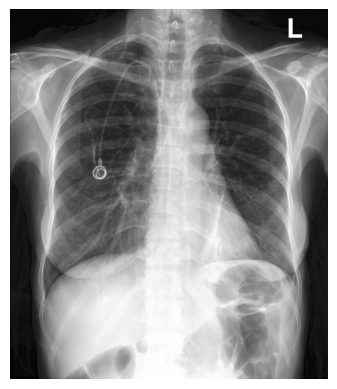

                                 FINAL REPORT
 HISTORY:  Metastatic colon cancer for developing pneumonia.  
 
 COMPARISON:  Chest radiograph from ___ and CT Torso from ___.  
 
 FINDINGS:
 
 Known bilateral small pulmonary nodules are noted but not clearly delineated
 on this study.  Linear left basilar atelectasis is again noted.  Otherwise the
 lungs are without any new focal consolidation, effusion or pneumothorax. 
 Cardiac and mediastinal contours are stable and within normal limits. 
 Right-sided Port-A-Cath tip in the mid SVC.  
 
 IMPRESSION:
 
 No evidence of pneumonia.  Known small pulmonary nodules are noted but not
 clearly delineated on this study.



In [ ]:
import matplotlib.pyplot as plt

sample = eval_dataset[100]

# Visualize
image = sample["messages"][0]["content"][1]["image"]
report_text = sample["messages"][1]["content"][0]["text"]

import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis("off")
plt.show()
print(report_text)


In [ ]:
# !pip install bert_score -q
# from evaluate import load

In [ ]:
from evaluate import load

# Load once (optional to cache across runs)
bleu_metric = load("bleu")
bertscore_metric = load("bertscore")

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # BLEU
    bleu = bleu_metric.compute(predictions=[p.split() for p in decoded_preds],
                               references=[[l.split()] for l in decoded_labels])

    # BERTScore (on GPU with a small model)
    bert = bertscore_metric.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        model_type="microsoft/distilbert-base-uncased",  # ✅ Small model
        lang="en",
        device="cuda"  # ✅ GPU!
    )

    return {
        "bleu": bleu["bleu"],
        "bertscore_precision": sum(bert["precision"]) / len(bert["precision"]),
        "bertscore_recall": sum(bert["recall"]) / len(bert["recall"]),
        "bertscore_f1": sum(bert["f1"]) / len(bert["f1"]),
    }


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [ ]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = train_dataset,
    eval_dataset=eval_dataset, # ✅ Add evaluation dataset
    compute_metrics = compute_metrics,  # ✅ add compute
    args = SFTConfig(
        per_device_train_batch_size = 4,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        # max_steps = None,
        num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "wandb",     # For Weights and Biases
        eval_steps=100,          # Evaluate every 100 steps

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA L4. Max memory = 22.161 GB.
10.279 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 13,679 | Num Epochs = 1 | Total steps = 855
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 52,428,800/11,000,000,000 (0.48% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,1.741000
2,1.855600
3,1.779600
4,1.860000
5,1.491200
6,1.568300
7,1.479400
8,1.360500
9,1.490300
10,1.452100


Step,Training Loss
1,1.741000
2,1.855600
3,1.779600
4,1.860000
5,1.491200
6,1.568300
7,1.479400
8,1.360500
9,1.490300
10,1.452100


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

5884.8164 seconds used for training.
98.08 minutes used for training.
Peak reserved memory = 10.459 GB.
Peak reserved memory for training = 2.008 GB.
Peak reserved memory % of max memory = 70.952 %.
Peak reserved memory for training % of max memory = 13.622 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!
sample = test_dataset[100]
image =  sample["messages"][0]["content"][1]["image"]
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

                                 FINAL REPORT
 HISTORY:  Hypoxia.
 
 TECHNIQUE:  PA and lateral views of the chest.
 
 COMPARISON:  ___.
 
 FINDINGS:
 
 There is unchanged prominence of the azygos contour, and bilateral diffuse
 reticulonodular opacities which may be due to patient's history of emphysema. 
 No large pleural effusion is identified.  No pneumothorax is present.  The
 cardiac and mediastinal contours are stable, and aortic knob calcification is
 redemonstrated.  No acute osseous abnormality


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
model.push_to_hub("parsa-mhmdi/LLama_VLM_3.2_4bit", token = hf_token) # Online saving
tokenizer.push_to_hub("parsa-mhmdi/LLama_VLM_3.2_4bit", token = hf_token) # Online saving
model.push_to_hub_merged("parsa-mhmdi/LLama_VLM_3.2_4bit_merged", tokenizer, token = hf_token)

README.md:   0%|          | 0.00/634 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/210M [00:00<?, ?B/s]

Saved model to https://huggingface.co/parsa-mhmdi/LLama_VLM_3.2_4bit


tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

model.safetensors.index.json:   0%|          | 0.00/89.4k [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:   0%|          | 0/5 [00:00<?, ?it/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  20%|██        | 1/5 [09:38<38:33, 578.49s/it]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  40%|████      | 2/5 [19:13<28:49, 576.44s/it]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  60%|██████    | 3/5 [28:14<18:40, 560.21s/it]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  80%|████████  | 4/5 [37:15<09:12, 552.62s/it]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 5/5 [41:48<00:00, 501.62s/it]


Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

Panoramic radiograph of the jaw showing well-defined radiolucency (arrowheads) of the right side and unerupted second permanent maxillary molar (arrow).<|eot_id|>


### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
# if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# To export and save to your Hugging Face account
model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", tokenizer, token = "PUT_HERE")

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Train your own reasoning model - Llama GRPO notebook [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.1_(8B)-GRPO.ipynb)
2. Saving finetunes to Ollama. [Free notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Ollama.ipynb)
3. Llama 3.2 Vision finetuning - Radiography use case. [Free Colab](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3.2_(11B)-Vision.ipynb)
6. See notebooks for DPO, ORPO, Continued pretraining, conversational finetuning and more on our [documentation](https://docs.unsloth.ai/get-started/unsloth-notebooks)!

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

  Join Discord if you need help + ⭐️ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐️
</div>


# Chain of thought training

#### Fix the bug

In [ ]:
!pip install -U huggingface_hub transformers safetensors -q
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')
!huggingface-cli login --token $hf_token

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `for mini_gemini` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `for mini_gemini`


In [ ]:
!pip install hf_transfer -q -U
%env HF_HUB_ENABLE_HF_TRANSFER=1

env: HF_HUB_ENABLE_HF_TRANSFER=1


In [ ]:
from huggingface_hub import snapshot_download
snapshot_download(
    repo_id="parsa-mhmdi/Reasoning_LLama_VLM_3.2_4bit_merged",
    local_dir="llama_fixed",
    local_dir_use_symlinks=False,   # we need the actual .safetensors files
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:933: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


.gitattributes:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/604 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:933: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:933: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


model-00001-of-00005.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:933: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:933: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:933: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:933: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:933: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:933: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/56.1k [00:00<?, ?B/s]

'/content/llama_fixed'

In [ ]:
import glob, json, os
from safetensors import safe_open

shards   = sorted(glob.glob("llama_fixed/model-*.safetensors"))
weight_map, total_size = {}, 0

for shard in shards:
    with safe_open(shard, framework="pt", device="cpu") as f:
        for key in f.keys():
            # store only the file name, not the full local path ⇣
            weight_map[key] = os.path.basename(shard)
    total_size += os.path.getsize(shard)

index = {"weight_map": weight_map, "metadata": {"total_size": total_size}}
json.dump(index, open("llama_fixed/model.safetensors.index.json", "w"))
print("✓ wrote model.safetensors.index.json")

✓ wrote model.safetensors.index.json


In [ ]:
!huggingface-cli upload \
  parsa-mhmdi/Reasoning_LLama_VLM_3.2_4bit_merged \
  llama_fixed/model.safetensors.index.json \
  --token $hf_token

https://huggingface.co/parsa-mhmdi/Reasoning_LLama_VLM_3.2_4bit_merged/blob/main/model.safetensors.index.json


### Installation

#### main code

In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

### Unsloth

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    model_name="parsa-mhmdi/LLama_VLM_3.2_4bit_merged",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    max_seq_length= 2048,
    use_gradient_checkpointing = "unsloth" # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.19: Fast Mllama patching. Transformers: 4.51.1.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

### Lora Config

In [ ]:
from unsloth import FastVisionModel
from peft import LoraConfig  # only if you need to pass a custom object

model = FastVisionModel.get_peft_model(
    model,

    # freeze vision backbone for small update
    finetune_vision_layers     = False,
    # we only tweak language attention
    finetune_language_layers   = True,
    finetune_attention_modules = True,
    finetune_mlp_modules       = False,        # <- change

    # LoRA hyper‑params
    r            = 8,                          # smaller rank
    lora_alpha   = 8,                         # scale ≈ r
    lora_dropout = 0.2,                       # add dropout
    bias         = "none",
    random_state = 3407,

    use_rslora   = True,                       # rank‑stabilised LoRA
    target_modules       = ["q_proj", "k_proj", "v_proj", "o_proj"],
    layers_to_transform  = "top-8",        # or "top-8" etc.
    loftq_config = None,
)


Unsloth: Making `model.base_model.model.vision_model.transformer` require gradients


### New Way to load the data

In [ ]:
!git lfs install
!pip install hf_transfer -q -U
%env HF_HUB_ENABLE_HF_TRANSFER=1
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')
!huggingface-cli login --token $hf_token

Git LFS initialized.
env: HF_HUB_ENABLE_HF_TRANSFER=1
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `for mini_gemini` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `for mini_gemini`


In [ ]:
# Download the dataset
!huggingface-cli download parsa-mhmdi/CoT-300-p14 --repo-type dataset --local-dir /content/raw_dataset

.gitattributes: 100% 2.46k/2.46k [00:00<00:00, 19.1MB/s]
Download complete. Moving file to /content/raw_dataset/.gitattributes
CoT-300-p14.zip: 100% 258M/258M [00:00<00:00, 319MB/s]
Download complete. Moving file to /content/raw_dataset/CoT-300-p14.zip
/content/raw_dataset


In [ ]:
# Unzip all needed files in parallel where possible
# Use background jobs with `&` and wait at the end
!7z x -aos /content/raw_dataset/CoT-300-p14.zip -o/content/dataset

# Clean up zip files after extraction
!rm /content/raw_dataset/CoT-300-p14.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,12 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (50657),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/raw_dataset/                               1 file, 258024056 bytes (247 MiB)

Extracting archive: /content/raw_dataset/CoT-300-p14.zip
--
Path = /content/raw_dataset/CoT-300-p14.zip
Type = zip
Physical Size = 258024056

  0%      7% 37 - CoT-300-p14/p14676772/s56879591 . -0d37728b-3c6a8bf1-65112720.jpg                                                                            15% 74 - CoT-300-p14/p14695209/s54559539 . -39873ade-d7c891da-68adce59.jpg 

In [ ]:
# Clean up entire raw dataset folder
!rm -r /content/raw_dataset

# Move and flatten the extracted directory structure
!mv /content/dataset/CoT-300-p14 /content/dataset/files

# Remove now-empty directories
# !rm -r /content/dataset/content


In [ ]:
# import os
# from pathlib import Path
# import random
# from PIL import Image
# from torch.utils.data import Dataset

# class FolderVisionTextDataset(Dataset):
#     """
#     Walks a MIMIC‑style folder tree (jpgs + sXXXXXXX.txt) and creates
#     one (image, report) sample **per jpg**, so multi‑image studies
#     yield multiple training examples using the same report.
#     """
#     def __init__(
#         self,
#         root_dir: str,
#         instruction: str,
#         split: str = "train",          # "train" | "val" | "test"
#         train_ratio: float = 0.95,
#         val_ratio:   float = 0.05,
#         seed: int = 42,
#     ):
#         self.root_dir   = Path(root_dir)
#         self.instruction = instruction

#         # ---------------------------------------------------------
#         # 1) Scan folders → build list of (jpg_path, report_path)
#         # ---------------------------------------------------------
#         samples = []
#         for patient_dir in self.root_dir.rglob("p1*"):   # matches p10 … p19
#             if not patient_dir.is_dir():
#                 continue

#             for study_dir in patient_dir.glob("s*"):
#                 if not study_dir.is_dir():
#                     continue

#                 report_file = patient_dir / f"{study_dir.name}.txt"
#                 if not report_file.exists():
#                     continue

#                 jpg_files = list(study_dir.glob("*.jpg"))
#                 for jpg in jpg_files:                    # ⬅ one sample per jpg
#                     samples.append({"img": jpg, "txt": report_file})

#         if not samples:
#             raise RuntimeError("No (image, report) samples found!")

#         # ---------------------------------------------------------
#         # 2) Shuffle and split
#         # ---------------------------------------------------------
#         random.Random(seed).shuffle(samples)
#         n = len(samples)
#         train_end = int(train_ratio * n)
#         val_end   = int((train_ratio + val_ratio) * n)

#         if split == "train":
#             self.samples = samples[:train_end]
#         elif split == "val":
#             self.samples = samples[train_end:val_end]
#         elif split == "test":
#             self.samples = samples[val_end:]
#         else:
#             raise ValueError("split must be 'train', 'val', or 'test'")

#         print(f"✅ {split.upper()} dataset size: {len(self.samples)} image‑report pairs")

#     # ---------------------------------------------------------
#     # PyTorch interface
#     # ---------------------------------------------------------
#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         if isinstance(idx, (list, tuple)):   # handle [idx] case
#             idx = idx[0]

#         sample = self.samples[idx]
#         img_path = sample["img"]
#         txt_path = sample["txt"]

#         image = Image.open(img_path).convert("RGB")
#         try:
#             with open(txt_path, "r", encoding="utf‑8", errors="ignore") as f:
#                 report_text = f.read()
#         except:
#             report_text = ""

#         return {
#             "messages": [
#                 {
#                     "role": "user",
#                     "content": [
#                         {"type": "text",  "text": self.instruction},
#                         {"type": "image", "image": image}
#                     ]
#                 },
#                 {
#                     "role": "assistant",
#                     "content": [
#                         {"type": "text",  "text": report_text}
#                     ]
#                 }
#             ]
#         }


In [ ]:
### New way small size images

import os, random, hashlib
from pathlib import Path
from PIL import Image, ImageOps
from torch.utils.data import Dataset

class FolderVisionTextDataset(Dataset):
    """
    MIMIC‑style jpg+txt loader that:
      • emits ONE (image, report) per jpg
      • resizes every image to <target_height,target_width>
        (default 896×672 portrait) with letter‑boxing
      • optional cache so heavy resize runs only once
    """
    def __init__(
        self,
        root_dir: str,
        instruction: str,
        split: str = "train",          # "train" | "val" | "test"
        train_ratio: float = 0.95,
        val_ratio:   float = 0.05,
        target_height: int = 896,      # <=1120, >=300
        target_width:  int = 672,
        cache_dir: str = None,         # e.g. "/content/resized_cache"
        seed: int = 42,
    ):
        self.root_dir    = Path(root_dir)
        self.instruction = instruction
        self.th, self.tw = target_height, target_width

        if self.th > 1120 or self.tw > 1120:
            raise ValueError("target dimensions must be ≤ 1120")

        # 1) Scan folders
        samples = []
        for patient_dir in self.root_dir.rglob("p1*"):
            if not patient_dir.is_dir():
                continue
            for study_dir in patient_dir.glob("s*"):
                if not study_dir.is_dir():
                    continue
                report = patient_dir / f"{study_dir.name}.txt"
                if not report.exists():
                    continue
                for jpg in study_dir.glob("*.jpg"):
                    samples.append({"img": jpg, "txt": report})
        if not samples:
            raise RuntimeError("No image‑report pairs found")

        # 2) Shuffle & split
        random.Random(seed).shuffle(samples)
        n = len(samples)
        tr, vr = int(train_ratio*n), int((train_ratio+val_ratio)*n)
        self.samples = (
            samples[:tr] if split=="train" else
            samples[tr:vr] if split=="val" else
            samples[vr:] if split=="test" else
            (_ for _ in ()).throw(ValueError("split must be train|val|test"))
        )
        print(f"✅ {split.upper()} set: {len(self.samples)} pairs "
              f"({self.th}×{self.tw}px each)")

        # 3) cache
        self.cache_dir = Path(cache_dir) if cache_dir else None
        if self.cache_dir: self.cache_dir.mkdir(parents=True, exist_ok=True)

    # ------------ helper ---------------------------------------------------
    def _load_resized(self, img_path: Path) -> Image.Image:
        if self.cache_dir:
            key  = hashlib.md5(str(img_path).encode()).hexdigest()+".jpg"
            cpth = self.cache_dir / key
            if cpth.exists():
                return Image.open(cpth).convert("RGB")

        img = Image.open(img_path).convert("RGB")
        img.thumbnail((self.tw, self.th), Image.LANCZOS)            # keep aspect
        img = ImageOps.pad(img, (self.tw, self.th), color=(0,0,0))  # letter‑box

        if self.cache_dir:
            img.save(cpth, "JPEG", quality=95)
        return img

    # ------------ PyTorch interface ---------------------------------------
    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        if isinstance(idx, (list, tuple)): idx = idx[0]

        sample = self.samples[idx]
        image  = self._load_resized(sample["img"])

        try:
            with open(sample["txt"], "r", encoding="utf‑8", errors="ignore") as f:
                report = f.read()
        except: report = ""

        return {
            "messages":[
                {"role":"user","content":[
                    {"type":"text", "text": self.instruction},
                    {"type":"image","image": image}]},
                {"role":"assistant","content":[
                    {"type":"text","text": report}]},
            ]
        }


In [ ]:
instruction = """
    "You are a board‑certified radiologist.\n"
    "1. Look at the chest‑X‑ray image.\n"
    "2. Think out loud and write a numbered, step‑by‑step reasoning path that "
    "covers lungs, pleura, heart, mediastinum, diaphragm and bones.\n"
    "3. After the reasoning, output an official structured radiology report "
    "using **exactly** these headings:\n"
    "   **Modality:**\n"
    "   **Part:**\n"
    "   **Technique:**\n"
    "   **Findings:**\n"
    "   **Impression:**\n"
    "— Do **not** invent findings that contradict the image or the reasoning.\n"
    "— Keep the final report concise and clinically formatted.\n"
    "Begin with “Step‑by‑step reasoning:” on a new line, then the numbered list, "
    "then a blank line, then the structured report."
"""
dir = "/content/dataset/files"
# train_dataset = FolderVisionTextDataset(
#     root_dir   = dir,     # or "/content/files" if you want all p10‑p19
#     instruction=instruction,
#     split      ="train",                   # "val" or "test" too
# )

# eval_dataset   = FolderVisionTextDataset(dir, instruction, split="val")

### New way
train_dataset = FolderVisionTextDataset(
    root_dir=dir,
    instruction=instruction,
    split="train",
    target_height=896, target_width=672,    # within 300–1000 and <1120
    cache_dir="/content/resized_cache"
)

eval_dataset   = FolderVisionTextDataset(
    dir, instruction, split="val",
    target_height=896, target_width=672,
    cache_dir="/content/resized_cache"
)



✅ TRAIN set: 156 pairs (896×672px each)
✅ VAL set: 9 pairs (896×672px each)


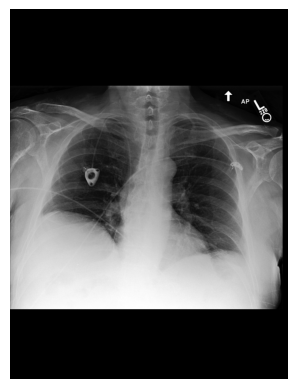

### Step-by-Step Reasoning:

1. **Review Clinical Information and Indication:** The patient is an adult male presenting with cough and confusion, and the examination is to evaluate for pneumonia. This raises suspicion for respiratory pathology, especially infection.

2. **Identify Modality and Technique:** The report states "CHEST (AP AND LAT)" and the image label shows "AP".  Although the report mentions lateral view, only the AP view image is provided.  Therefore, the modality is X-ray, and the view is AP upright.  For the structured report, assuming a standard chest X-ray, we can specify Technique as "Standard posteroanterior projection" even if only AP is provided, as PA is the standard unless specified otherwise.

3. **Assess Technical Quality:**  Evaluate the image for overall quality, including penetration, inspiration, and rotation. The image appears reasonably well-penetrated as we can see the vertebral bodies through the heart. The clavicles are relatively symmetrical, sugges

In [ ]:
import matplotlib.pyplot as plt

sample = train_dataset[57]

# Visualize
image = sample["messages"][0]["content"][1]["image"]
report_text = sample["messages"][1]["content"][0]["text"]

import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis("off")
plt.show()
print(report_text)


In [ ]:
from tqdm import tqdm
import numpy as np

def get_token_lengths_text_only(dataset, tokenizer):
    lengths = []

    for sample in tqdm(dataset):
        try:
            assistant_text = sample["messages"][1]["content"][0]["text"]
        except:
            continue

        # Tokenize only the text, ignoring image modality
        tokenized = tokenizer.tokenizer(assistant_text, return_tensors="pt", truncation=False)
        lengths.append(tokenized.input_ids.shape[1])

    return np.array(lengths)

lengths = get_token_lengths_text_only(train_dataset, tokenizer)

print("🔍 Token length stats:")
print(f"Max: {lengths.max()} tokens")
print(f"95th percentile: {np.percentile(lengths, 95):.0f}")
print(f"Mean: {lengths.mean():.1f}")
print(f"Std:  {lengths.std():.1f}")


100%|██████████| 156/156 [00:28<00:00,  5.50it/s]

🔍 Token length stats:
Max: 1672 tokens
95th percentile: 1408
Mean: 1117.4
Std:  183.8


### Training Config

In [ ]:
!pip install bert_score -q
!pip install evaluate -q
from evaluate import load

In [ ]:
# Load once (optional to cache across runs)
bleu_metric = load("bleu")
bertscore_metric = load("bertscore")

def compute_metrics(eval_preds):
    preds, labels = eval_preds

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # BLEU
    bleu = bleu_metric.compute(predictions=[p.split() for p in decoded_preds],
                               references=[[l.split()] for l in decoded_labels])

    # BERTScore (on GPU with a small model)
    bert = bertscore_metric.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        model_type="bert-base-uncased",  # ✅ Small model
        lang="en",
        device="cpu"  # ✅ GPU!
    )

    return {
        "bleu": bleu["bleu"],
        "bertscore_precision": sum(bert["precision"]) / len(bert["precision"]),
        "bertscore_recall": sum(bert["recall"]) / len(bert["recall"]),
        "bertscore_f1": sum(bert["f1"]) / len(bert["f1"]),
    }


In [ ]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
from transformers import EarlyStoppingCallback
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
FastVisionModel.for_training(model)

trainer = SFTTrainer(
    model         = model,
    tokenizer     = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer),
    train_dataset = train_dataset,

    # No eval_dataset, no compute_metrics, no callbacks
    args = SFTConfig(
        per_device_train_batch_size     = 4,
        gradient_accumulation_steps     = 1,
        num_train_epochs                = 10,
        learning_rate                   = 1e-4,
        warmup_steps                    = 50,
        weight_decay                    = 0.01,
        lr_scheduler_type               = "linear",
        fp16                            = not is_bf16_supported(),
        bf16                            = is_bf16_supported(),
        logging_steps                   = 2,

        # Removed evaluation + early stopping related fields
        # save_strategy                   = "steps",
        # save_steps                      = 150,
        save_strategy                   = "epoch",
        save_total_limit                = 3,
        output_dir                      = "outputs",
        optim                           = "adamw_8bit",

        # vision-specific settings
        remove_unused_columns           = False,
        dataset_text_field              = "",
        dataset_kwargs                  = {"skip_prepare_dataset": True},
        dataset_num_proc                = 2,
        max_seq_length                  = 2048,
        seed                            = 3407,
        report_to                       = "wandb",
    ),
)

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 156 | Num Epochs = 10 | Total steps = 390
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 1 x 1) = 4
 "-____-"     Trainable parameters = 11,796,480/4,000,000,000 (0.29% trained)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: parsa-mhmdi (parsa-mhmdi-wu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss
2,1.936300
4,2.018200
6,1.976900
8,2.025000
10,1.933700
12,1.964300
14,1.964800
16,1.886500
18,1.819200
20,1.825000


Unsloth: Will smartly offload gradients to save VRAM!


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!
sample = train_dataset[57]
image =  sample["messages"][0]["content"][1]["image"]
instruction = """
    "You are a board‑certified radiologist.\n"
    "1. Look at the chest‑X‑ray image.\n"
    "2. Think out loud and write a numbered, step‑by‑step reasoning path that "
    "covers lungs, pleura, heart, mediastinum, diaphragm and bones.\n"
    "3. After the reasoning, output an official structured radiology report "
    "using **exactly** these headings:\n"
    "   **Modality:**\n"
    "   **Part:**\n"
    "   **Technique:**\n"
    "   **Findings:**\n"
    "   **Impression:**\n"
    "— Do **not** invent findings that contradict the image or the reasoning.\n"
    "— Keep the final report concise and clinically formatted.\n"
    "Begin with “Step‑by‑step reasoning:” on a new line, then the numbered list, "
    "then a blank line, then the structured report."
"""

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 2048,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

 WET READ:  ___ ___ 7:40 PM
  1. New moderate-to-large bilateral pleural effusions. Lungs appear atelectatic,
  likely small bilateral pneumonia or pleural effusions versus consolidation
  or collapse versus aspiration.
  2. Mild bibasilar atelectasis is likely related to effusions.
  3. Cardiac size is top normal and likely mildly increased.
  4. There is likely some superimposed mild edema.
  5. There are likely new mediastinal lymph nodes on the right.
  6. There is likely a new right lateral rib fracture, may need radiograph of
  the chest side for better evaluation.
  7. No pleural drain seen.
  
  ______________________________________________________________________________
  __NOTICE: This report remains confidential and for hospital/clinical use only.
  Clinical findings and final assessment must be included in the formal report.
  A summary for patient or referring physician without diagnosis is okay. __
  ______________________________________________________________________

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
model.push_to_hub("parsa-mhmdi/reasoning_LLama_VLM_3.2_4bit", token = hf_token) # Online saving
tokenizer.push_to_hub("parsa-mhmdi/reasoning_LLama_VLM_3.2_4bit", token = hf_token) # Online saving
model.push_to_hub_merged("parsa-mhmdi/reasoning_LLama_VLM_3.2_4bit_merged", tokenizer, token = hf_token, safe_serialization=True )

No files have been modified since last commit. Skipping to prevent empty commit.


Saved model to https://huggingface.co/parsa-mhmdi/reasoning_LLama_VLM_3.2_4bit


No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


Unsloth: Merging weights into 16bit:  20%|██        | 1/5 [00:46<03:07, 46.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  40%|████      | 2/5 [02:17<03:38, 72.89s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  60%|██████    | 3/5 [03:47<02:40, 80.44s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit:  80%|████████  | 4/5 [05:22<01:26, 86.26s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 5/5 [05:57<00:00, 71.41s/it]


Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

Panoramic radiograph of the jaw showing well-defined radiolucency (arrowheads) of the right side and unerupted second permanent maxillary molar (arrow).<|eot_id|>


# Evaluation

## Load the base model

### Installation

In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
    !pip install --no-deps unsloth

### Unsloth

In [ ]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "parsa-mhmdi/Reasoning_LLama_VLM_3.2_4bit_merged",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
Unsloth: Failed to patch Gemma3ForConditionalGeneration.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.3.19: Fast Mllama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

## Load the dataset

In [ ]:
!git lfs install
!pip install hf_transfer -q -U
%env HF_HUB_ENABLE_HF_TRANSFER=1
from google.colab import userdata
hf_token = userdata.get('HF_TOKEN')
!huggingface-cli login --token $hf_token

Git LFS initialized.
env: HF_HUB_ENABLE_HF_TRANSFER=1
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `for mini_gemini` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `for mini_gemini`


In [ ]:
# Download the dataset
!huggingface-cli download parsa-mhmdi/small_data --repo-type dataset --local-dir /content/raw_dataset

# Unzip all needed files in parallel where possible
# Use background jobs with `&` and wait at the end
!7z x -aos /content/raw_dataset/toplevel.zip -o/content/dataset &
!7z x -aos /content/raw_dataset/p14.zip -o/content/dataset &

# Wait for all background jobs to finish
!wait

# Clean up zip files after extraction
!rm /content/raw_dataset/toplevel.zip /content/raw_dataset/p14.zip

# Clean up entire raw dataset folder
!rm -r /content/raw_dataset

# Move and flatten the extracted directory structure
!mv /content/dataset/content/MIMIC_dataset/* /content/dataset/

# Remove now-empty directories
!rm -r /content/dataset/content


.gitattributes: 100% 2.46k/2.46k [00:00<00:00, 16.9MB/s]
Download complete. Moving file to /content/raw_dataset/.gitattributes
p14.zip: 100% 22.4G/22.4G [03:18<00:00, 112MB/s]
Download complete. Moving file to /content/raw_dataset/p14.zip
toplevel.zip: 100% 211M/211M [00:00<00:00, 307MB/s]  
Download complete. Moving file to /content/raw_dataset/toplevel.zip
/content/raw_dataset

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,12 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (50657),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/raw_dataset/                               1 file, 210885064 bytes (202 MiB)

Extracting archive: /content/raw_dataset/toplevel.zip
  1% 4096 Open               76% 225280 Open                --
Path = /content/raw_dataset/toplevel.zip
Type = zi

In [ ]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

class RobustVisionTextDataset(Dataset):
    def __init__(self, record_csv, study_csv, root_dir, instruction, split='train'):
        # Load and merge CSVs
        df = pd.read_csv(record_csv)
        study_df = pd.read_csv(study_csv)
        df = pd.merge(df, study_df, on=['study_id', 'subject_id'])
        df.rename(columns={'path_x': 'img_path', 'path_y': 'report_path'}, inplace=True)

        self.root_dir = root_dir
        self.instruction = instruction

        # Filter valid images
        valid_rows = []
        for idx, row in df.iterrows():
            img_path = os.path.join(
                self.root_dir,
                row['img_path'].replace('.dcm', '.jpg')
            )
            # Only add rows whose images exist
            if os.path.exists(img_path):
                valid_rows.append(idx)

        # Split dataset
        total = len(valid_rows)
        train_end = int(0.99 * total)
        val_end = int(total)

        if split == 'train':
            subset_indices = valid_rows[:train_end]
        elif split == 'val':
            subset_indices = valid_rows[train_end:val_end]
        elif split == 'test':
            subset_indices = valid_rows[val_end:]
        else:
            raise ValueError("split must be 'train', 'val', or 'test'")

        # Keep only the subset; reset the index
        self.df = df.iloc[subset_indices].reset_index(drop=True)
        print(f"✅ {split.upper()} dataset size: {len(self.df)} pairs")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        """
        Some DataLoaders or HF .map() calls may pass lists of indices even if batch_size=1.
        We handle both single int and list-based indexing to prevent errors.
        """
        # If idx is a list/tuple/array (e.g., [100]), pick the first element
        if isinstance(idx, (list, tuple)):
            idx = idx[0]

        row = self.df.iloc[idx]

        # Build image path
        img_path = os.path.join(
            self.root_dir,
            row['img_path'].replace('.dcm', '.jpg')
        )
        # Build report path
        report_path = os.path.join(self.root_dir, row['report_path'])

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Load report
        try:
            with open(report_path, 'r', encoding='utf-8', errors='ignore') as f:
                report_text = f.read()
        except:
            report_text = ""

        # Return conversation in the format needed for vision-language training
        return {
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": self.instruction},
                        {"type": "image", "image": image}
                    ]
                },
                {
                    "role": "assistant",
                    "content": [
                        {"type": "text", "text": report_text}
                    ]
                }
            ]
        }


In [ ]:
instruction = instruction = """
    "You are a board‑certified radiologist.\n"
    "1. Look at the chest‑X‑ray image.\n"
    "2. Think out loud and write a numbered, step‑by‑step reasoning path that "
    "covers lungs, pleura, heart, mediastinum, diaphragm and bones.\n"
    "3. After the reasoning, output an official structured radiology report "
    "using **exactly** these headings:\n"
    "   **Modality:**\n"
    "   **Part:**\n"
    "   **Technique:**\n"
    "   **Findings:**\n"
    "   **Impression:**\n"
    "— Do **not** invent findings that contradict the image or the reasoning.\n"
    "— Keep the final report concise and clinically formatted.\n"
    "Begin with “Step‑by‑step reasoning:” on a new line, then the numbered list, "
    "then a blank line, then the structured report."
"""

train_dataset = RobustVisionTextDataset(
    '/content/dataset/cxr-record-list.csv',
    '/content/dataset/cxr-study-list.csv',
    '/content/dataset',
    instruction,
    split='train'
)

eval_dataset = RobustVisionTextDataset(
    '/content/dataset/cxr-record-list.csv',
    '/content/dataset/cxr-study-list.csv',
    '/content/dataset',
    instruction,
    split='val'
)

# test_dataset = RobustVisionTextDataset(
#     '/content/dataset/cxr-record-list.csv',
#     '/content/dataset/cxr-study-list.csv',
#     '/content/dataset',
#     instruction,
#     split='test'
# )


✅ TRAIN dataset size: 13819 pairs
✅ VAL dataset size: 140 pairs


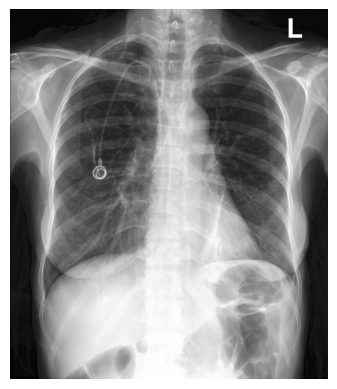

                                 FINAL REPORT
 HISTORY:  Metastatic colon cancer for developing pneumonia.  
 
 COMPARISON:  Chest radiograph from ___ and CT Torso from ___.  
 
 FINDINGS:
 
 Known bilateral small pulmonary nodules are noted but not clearly delineated
 on this study.  Linear left basilar atelectasis is again noted.  Otherwise the
 lungs are without any new focal consolidation, effusion or pneumothorax. 
 Cardiac and mediastinal contours are stable and within normal limits. 
 Right-sided Port-A-Cath tip in the mid SVC.  
 
 IMPRESSION:
 
 No evidence of pneumonia.  Known small pulmonary nodules are noted but not
 clearly delineated on this study.



In [ ]:
import matplotlib.pyplot as plt

sample = eval_dataset[100]

# Visualize
image = sample["messages"][0]["content"][1]["image"]
report_text = sample["messages"][1]["content"][0]["text"]

import matplotlib.pyplot as plt
plt.imshow(image)
plt.axis("off")
plt.show()
print(report_text)


## Evaluation

In [ ]:
# Install / import everything
!pip install bert_score tqdm rouge_score evaluate -q

import torch
from tqdm import tqdm
from unsloth import FastVisionModel
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from bert_score import score as bert_score
import evaluate

In [ ]:
# 1) Load metrics
meteor_metric = evaluate.load("meteor")
rouge_scorer_obj = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# 2) Prepare model
FastVisionModel.for_inference(model)
model.eval()

BATCH_SIZE = 16

def evaluate_model(model, tokenizer, dataset, instruction, device='cuda', batch_size=BATCH_SIZE):
    refs_for_bleu, hyps_for_bleu = [], []
    refs_str, hyps_str = [], []
    rouge_l_scores = []

    total = len(dataset)
    for start in tqdm(range(0, total, batch_size), desc="Evaluating Model"):
        end = min(start + batch_size, total)
        batch = [dataset[i] for i in range(start, end)]

        # --- gather images (nested) and reference texts
        images    = [[item["messages"][0]["content"][1]["image"]] for item in batch]
        refs_text = [item["messages"][1]["content"][0]["text"].strip()   for item in batch]

        # --- build batch inputs
        input_texts = [
            tokenizer.apply_chat_template(
                [{"role":"user","content":[{"type":"image"}, {"type":"text","text":instruction}]}],
                add_generation_prompt=True
            )
            for _ in images
        ]
        inputs = tokenizer(
            images,
            input_texts,
            add_special_tokens=False,
            return_tensors="pt",
            padding=True,
        ).to(device)

        # --- generate
        with torch.no_grad():
            generated = model.generate(
                **inputs,
                max_new_tokens=2048,   # unchanged
                temperature=0.5,
                min_p=0.1,
                use_cache=True,
                do_sample=False,
                eos_token_id=tokenizer.eos_token_id,
            )

        # --- decode + clean, accumulate
        for idx, gen in enumerate(generated):
            full = tokenizer.decode(gen, skip_special_tokens=True).strip()
            hyp  = full.split("assistant",1)[1].strip() if "assistant" in full else full

            hyps_str.append(hyp)
            refs_str.append(refs_text[idx])

            # for BLEU
            ref_tokens = refs_text[idx].split()
            hyp_tokens = hyp.split()
            refs_for_bleu.append([ref_tokens])
            hyps_for_bleu.append(hyp_tokens)

            # for ROUGE‑L
            rouge_l_scores.append(
                rouge_scorer_obj.score(refs_text[idx], hyp)['rougeL'].fmeasure
            )

    # 3) Compute BLEU‑4
    bleu4 = corpus_bleu(
        refs_for_bleu,
        hyps_for_bleu,
        smoothing_function=SmoothingFunction().method1
    )

    # 4) Compute ROUGE‑L average
    avg_rouge_l = sum(rouge_l_scores) / len(rouge_l_scores)

    # 5) Compute METEOR via HuggingFace evaluate (no WordNet issues)
    meteor_res = meteor_metric.compute(predictions=hyps_str, references=refs_str)
    avg_meteor = meteor_res["meteor"]

    # 6) Compute BERTScore
    P, R, F1 = bert_score(
        hyps_str,
        refs_str,
        lang='en',
        rescale_with_baseline=True,
        device=device,
    )
    avg_p  = P.mean().item()
    avg_r  = R.mean().item()
    avg_f1 = F1.mean().item()

    # 7) Print
    print("\n🚀 Evaluation Results:")
    print(f"🔹 BLEU‑4   : {bleu4:.4f}")
    print(f"🔹 ROUGE‑L  : {avg_rouge_l:.4f}")
    print(f"🔹 METEOR   : {avg_meteor:.4f}")
    print(f"🔹 BERTScore: P {avg_p:.4f} / R {avg_r:.4f} / F1 {avg_f1:.4f}")

# 8) Run it
instruction = "You are an expert radiographer. Describe accurately what you see in this image."
evaluate_model(model, tokenizer, eval_dataset, instruction)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Evaluating Model:   0%|          | 0/9 [00:00<?, ?it/s]